In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("Ïäù=3")

Ïäù=3


In [35]:
# Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© Î†àÏù¥Ïñ¥
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # Î∞∞Ïó¥Ïùò ÏßùÏàò Ïù∏Îç±Ïä§ÏóêÎäî sin Ìï®Ïàò Ï†ÅÏö©
    sines = tf.math.sin(angle_rads[:, 0::2])
    # Î∞∞Ïó¥Ïùò ÌôÄÏàò Ïù∏Îç±Ïä§ÏóêÎäî cosine Ìï®Ïàò Ï†ÅÏö©
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("Ïäù=3")

Ïäù=3


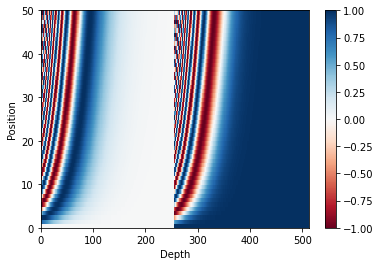

In [36]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# Ïñ¥ÌÖêÏÖò


## Ïñ¥ÌÖêÏÖò
1. Ïù∏ÏΩîÎçî ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò: Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†•ÏúºÎ°ú Îì§Ïñ¥Í∞Ñ Î¨∏Ïû• ÎÇ¥ Îã®Ïñ¥Îì§Ïù¥ ÏÑúÎ°ú Ïú†ÏÇ¨ÎèÑÎ•º Íµ¨Ìï®.
2. ÎîîÏΩîÎçî ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò: Îã®Ïñ¥Î•º 1Í∞úÏî© ÏÉùÏÑ±ÌïòÎäî ÎîîÏΩîÎçîÍ∞Ä Ïù¥ÎØ∏ ÏÉùÏÑ±Îêú Ïïû Îã®Ïñ¥Îì§Í≥ºÏùò Ïú†ÏÇ¨ÎèÑÎ•º Íµ¨Ìï®.
3. Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò: ÎîîÏΩîÎçîÍ∞Ä Ïûò ÏòàÏ∏°ÌïòÍ∏∞ ÏúÑÌï¥ Ïù∏ÏΩîÎçîÏóê ÏûÖÎ†•Îêú Îã®Ïñ¥Îì§Í≥º Ïú†ÏÇ¨ÎèÑ Íµ¨Ìï®

### ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò
- Ïú†ÏÇ¨ÎèÑÎ•º Íµ¨ÌïòÎäî ÎåÄÏÉÅÏù¥ Îã§Î•∏ Î¨∏Ïû•Ïùò Îã®Ïñ¥Í∞Ä ÏïÑÎãàÎùº ÌòÑÏû¨ Î¨∏Ïû• ÎÇ¥Ïùò Îã®Ïñ¥Îì§Ïù¥ ÏÑúÎ°ú Ïú†ÏÇ¨ÎèÑÎ•º Íµ¨ÌïòÎäî Í≤ΩÏö∞.

### Scaled Dot Product Attention
- Ïú†ÏÇ¨ÎèÑÎ•º Íµ¨ÌïòÎäî Î∞©Î≤ï
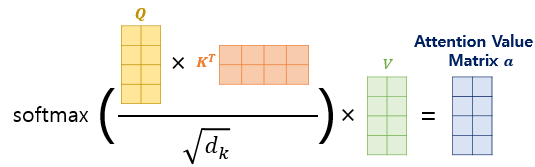

$Attention(Q,K,V) = softmax \left( \frac {QK^T} {\sqrt{d_k}} \right) V$



In [37]:
# Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
def scaled_dot_product_attention(query, key, value, mask):
  """Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπòÎ•º Í≥ÑÏÇ∞. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output
print("Ïäù=3")

Ïäù=3


### multi head attention
- Î≥ëÎ†πÎ°ú Ïñ¥ÌÖêÏÖò ÏàòÌñâ.
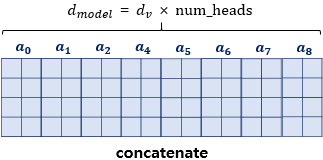

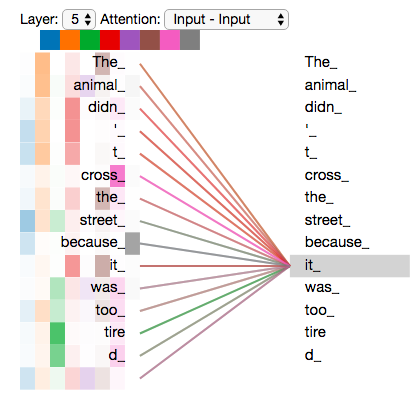

In [38]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Î≥ëÎ†¨ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌïú Î®∏Î¶¨Î•º Ïó¨Îü¨ Í∞ú ÎßåÎì≠ÎãàÎã§.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Ïä§ÏºÄÏùºÎìú Îã∑-ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # Ïñ¥ÌÖêÏÖò Ïó∞ÏÇ∞ ÌõÑÏóê Í∞Å Í≤∞Í≥ºÎ•º Îã§Ïãú Ïó∞Í≤∞(concatenate)Ìï©ÎãàÎã§.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs
print("Ïäù=3")

Ïäù=3


## Masking

### Padding Masking:
- padding token Ïù¥Ïö©

In [39]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("Ïäù=3")

Ïäù=3


In [40]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### Look-ahead masking

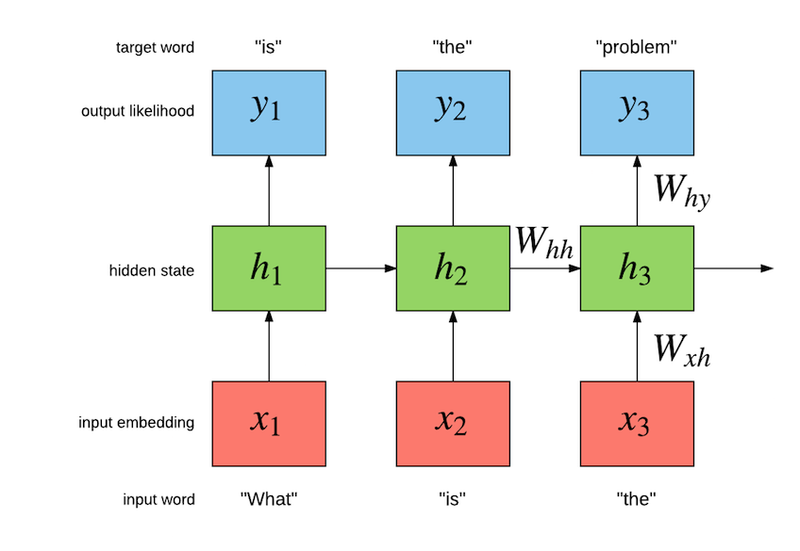



In [41]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("Ïäù=3")

Ïäù=3


In [42]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [43]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## Encoder
- 2Í∞úÏùò sublayerÎ°ú ÎÇòÎâòÏñ¥Ïßê
- ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò(Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò Î≥ëÎ†¨ Ïó∞Í≤∞), ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßù

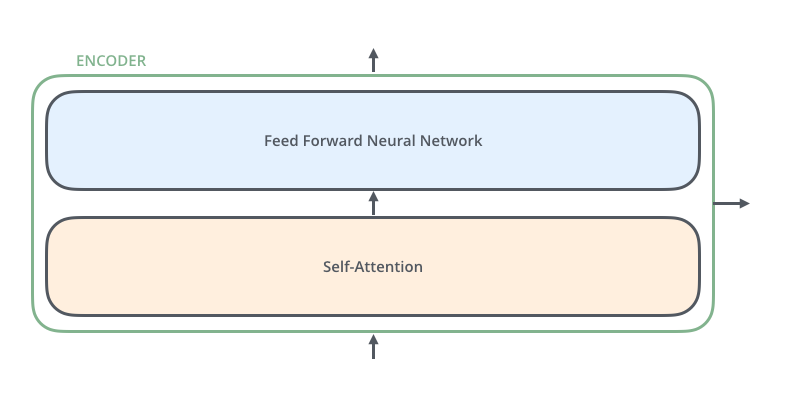

In [44]:
# Ïù∏ÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî Îëê Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Ï≤´Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º Layer NormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # ÎëêÎ≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("Ïäù‚ô•")

Ïäù‚ô•


In [45]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

    # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layersÎßåÌÅº ÏåìÏïÑÏò¨Î¶∞ Ïù∏ÏΩîÎçîÏùò Ï∏µ.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


## Decoder

- ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò, Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò(keyÏôÄ valudÍ∞Ä Ïù∏ÏΩîÎçîÏùò Î≤°ÌÑ∞), ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßù

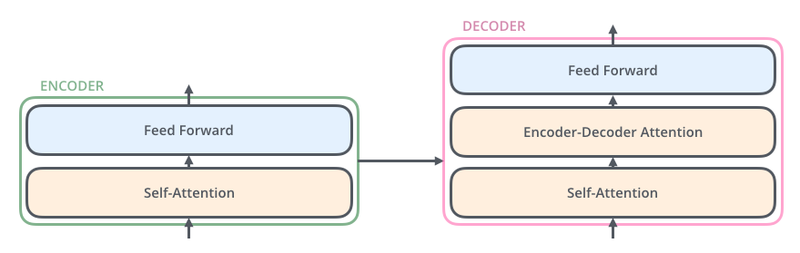

In [46]:
# ÎîîÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî ÏÑ∏ Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Ï≤´Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # ÎëêÎ≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî
  # DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # ÏÑ∏Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalization ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


In [47]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # Ìå®Îî© ÎßàÏä§ÌÅ¨
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # DropoutÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


## Ï±óÎ¥á Î≥ëÎ†¨ Îç∞Ïù¥ÌÑ∞ Î∞õÍ∏∞


In [48]:
import pandas as pd
import os
#csv_file = os.getenv('HOME')+'/aiffel/songys_chatbot/ChatbotData.csv'

df = pd.read_csv('sample_data/ChatbotData.csv')
df.head(2)

Q           A  label
0       12Ïãú Îï°!  ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.      0
1  1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥   ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.      0

In [49]:
# ÏÇ¨Ïö©Ìï† ÏÉòÌîåÏùò ÏµúÎåÄ Í∞úÏàò
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [61]:
# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
josa = pd.read_csv('sample_data/JOSA2.TXT', sep=" ", header=None)
eomi = pd.read_csv('sample_data/EOMI2.TXT', sep=" ", header=None)
stopwords = josa + eomi

In [97]:
def preprocess_sentence(data,tokenizer):
    text_data = []
    
    for sentence in data:
        temp_data = []
        #- ÌÜ†ÌÅ∞Ìôî
        #temp_data = tokenizer.morphs(sentence) 
        temp_data = sentence
        #- Î∂àÏö©Ïñ¥ Ï†úÍ±∞
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)
    
    text_data = list(map(' '.join, text_data))

    return text_data

In [65]:
!pip install konlpy
from konlpy.tag import Komoran
token_Komoran = Komoran()

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19.4MB 1.2MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 460kB 42.1MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 92kB 10.1MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [89]:
# # ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùò ÏåçÏù∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Íµ¨ÏÑ±ÌïòÍ∏∞ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
# def load_conversations():
#   id2line = {}
#   # with open('sample_data/ChatbotData.csv', errors='ignore') as file:
#   #   lines = file.readlines()
#   # for line in lines:
#   #   parts = line.replace('\n', '').split(' +++$+++ ')
#   #   id2line[parts[0]] = parts[4]

#   inputs, outputs = [], []

#   # for line in lines:
#   #   parts = line.replace('\n', '').split(' +++$+++ ')
#   #   conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

#   for i in range(len(df) - 1):
# 			# Ï†ÑÏ≤òÎ¶¨ Ìï®ÏàòÎ•º ÏßàÎ¨∏Ïóê Ìï¥ÎãπÎêòÎäî inputsÏôÄ ÎãµÎ≥ÄÏóê Ìï¥ÎãπÎêòÎäî outputsÏóê Ï†ÅÏö©.
#     inputs.append(preprocess_sentence(id2line[df.Q[i]], token_Komoran))
#     outputs.append(preprocess_sentence(id2line[df.A[i + 1]], token_Komoran))

#     if len(inputs) >= MAX_SAMPLES:
#       return inputs, outputs
#   return inputs, outputs
# print("Ïäù=3")

Ïäù=3


In [98]:
# Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌïòÍ≥† Ï†ÑÏ≤òÎ¶¨ÌïòÏó¨ ÏßàÎ¨∏ÏùÑ questions, ÎãµÎ≥ÄÏùÑ answersÏóê Ï†ÄÏû•Ìï©ÎãàÎã§.
#questions, answers = load_conversations()
questions = preprocess_sentence(df['Q'], token_Komoran)
answers = preprocess_sentence(df['A'], token_Komoran)
print('Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò :', len(questions))
print('Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò :', len(answers))

Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò : 11823
Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò : 11823


In [99]:
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(questions[21]))
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(answers[21]))

Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: Í∞Ä Ïä§ ÎπÑ   Ïû• ÎÇú   ÏïÑ Îãò
Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: Îã§ Ïùå   Îã¨ Ïóê Îäî   Îçî   Ï†à ÏïΩ Ìï¥ Î¥ê Ïöî .


## Î≥ëÎ†¨ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

### Vovabulary ÎßåÎì§Í∏∞

In [100]:
print("ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê")

# ÏßàÎ¨∏Í≥º ÎãµÎ≥Ä Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ÏÑú Vocabulary ÏÉùÏÑ±.
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("Ïäù=3 ")

ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê
Ïäù=3 


In [101]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê Í≥†Ïú†Ìïú Ï†ïÏàòÎ•º Î∂ÄÏó¨Ìï©ÎãàÎã§.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("Ïäù=3")

Ïäù=3


In [102]:
print('START_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size])
print('END_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size + 1])

START_TOKENÏùò Î≤àÌò∏ : [2192]
END_TOKENÏùò Î≤àÌò∏ : [2193]


In [103]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ +2Î•º ÌïòÏó¨ Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞Î•º ÏÇ∞Ï†ïÌï©ÎãàÎã§.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

2194


### Integer encoding & padding


In [104]:
# ÏûÑÏùòÏùò 22Î≤àÏß∏ ÏÉòÌîåÏóê ÎåÄÌï¥ÏÑú Ï†ïÏàò Ïù∏ÏΩîÎî© ÏûëÏóÖÏùÑ ÏàòÌñâ.
# Í∞Å ÌÜ†ÌÅ∞ÏùÑ Í≥†Ïú†Ìïú Ï†ïÏàòÎ°ú Î≥ÄÌôò
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(tokenizer.encode(questions[21])))
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(tokenizer.encode(answers[21])))

Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: [27, 106, 438, 1, 178, 340, 1, 9, 696]
Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: [30, 231, 1, 177, 44, 7, 1, 113, 1, 343, 402, 12, 74, 3, 2]


In [105]:
# ÏÉòÌîåÏùò ÏµúÎåÄ ÌóàÏö© Í∏∏Ïù¥ ÎòêÎäî Ìå®Îî© ÌõÑÏùò ÏµúÏ¢Ö Í∏∏Ïù¥.
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [106]:
# Ï†ïÏàò Ïù∏ÏΩîÎî©, ÏµúÎåÄ Í∏∏Ïù¥Î•º Ï¥àÍ≥ºÌïòÎäî ÏÉòÌîå Ï†úÍ±∞, Ìå®Îî©
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # Ï†ïÏàò Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ï∂îÍ∞Ä
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # ÏµúÎåÄ Í∏∏Ïù¥ 40Ïù¥ÌïòÏù∏ Í≤ΩÏö∞ÏóêÎßå Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌóàÏö©
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # ÏµúÎåÄ Í∏∏Ïù¥ 40ÏúºÎ°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìå®Îî©
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("Ïäù=3")

Ïäù=3


In [107]:
questions, answers = tokenize_and_filter(questions, answers)
print('Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ :',(VOCAB_SIZE))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏÉòÌîå Í∞úÏàò: {}'.format(len(questions)))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏÉòÌîå Í∞úÏàò: {}'.format(len(answers)))

Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ : 2194
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏÉòÌîå Í∞úÏàò: 11699
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏÉòÌîå Í∞úÏàò: 11699


### Teacher Forcing ÏÇ¨Ïö©

In [108]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# ÎîîÏΩîÎçîÎäî Ïù¥Ï†ÑÏùò targetÏùÑ Îã§ÏùåÏùò inputÏúºÎ°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
# Ïù¥Ïóê Îî∞Îùº outputsÏóêÏÑúÎäî START_TOKENÏùÑ Ï†úÍ±∞ÌïòÍ≤†ÏäµÎãàÎã§.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("Ïäù=3")

Ïäù=3


In [109]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# Ïù∏ÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # ÎîîÏΩîÎçîÏóêÏÑú ÎØ∏ÎûòÏùò ÌÜ†ÌÅ∞ÏùÑ ÎßàÏä§ÌÅ¨ÌïòÍ∏∞ÏúÑÌï¥ÏÑú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
  # ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ìå®Îî© ÎßàÏä§ÌÅ¨ÎèÑ Ìè¨Ìï®ÎêòÏñ¥Ï†∏ ÏûàÏäµÎãàÎã§.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # ÎëêÎ≤àÏß∏ Ïñ¥ÌÖêÏÖò Î∏îÎ°ùÏóêÏÑú Ïù∏ÏΩîÎçîÏùò Î≤°ÌÑ∞Îì§ÏùÑ ÎßàÏä§ÌÇπ
  # ÎîîÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # Ïù∏ÏΩîÎçî
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # ÎîîÏΩîÎçî
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


## Î™®Îç∏ ÏÉùÏÑ±

In [110]:
tf.keras.backend.clear_session()

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
NUM_LAYERS = 2 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçîÏùò Ï∏µÏùò Í∞úÏàò
D_MODEL = 256 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçî ÎÇ¥Î∂ÄÏùò ÏûÖ, Ï∂úÎ†•Ïùò Í≥†Ï†ï Ï∞®Ïõê
NUM_HEADS = 8 # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏóêÏÑúÏùò Ìó§Îìú Ïàò 
UNITS = 512 # ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò ÏùÄÎãâÏ∏µÏùò ÌÅ¨Í∏∞
DROPOUT = 0.1 # ÎìúÎ°≠ÏïÑÏõÉÏùò ÎπÑÏú®

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    1615872     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## Loss Function

In [111]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("Ïäù=3")

Ïäù=3


## Learning Rate
$lrate = d_{model}^{-0.5} \cdot min({step\_num}^{-0.5}, {step\_num} \cdot {warmup\_steps}^{-1.5})$

In [112]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("Ïäù=3")

Ïäù=3


Text(0.5, 0, 'Train Step')

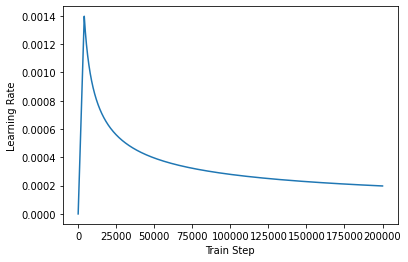

In [113]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Model Compile

In [114]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("Ïäù=3")

Ïäù=3


## ÌõàÎ†®ÌïòÍ∏∞

In [115]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
183/183 [==============================] - 228s 1s/step - loss: 2.6470 - accuracy: 0.0541
Epoch 2/20
183/183 [==============================] - 233s 1s/step - loss: 1.7599 - accuracy: 0.1347
Epoch 3/20
183/183 [==============================] - 227s 1s/step - loss: 1.3393 - accuracy: 0.1718
Epoch 4/20
183/183 [==============================] - 230s 1s/step - loss: 1.1490 - accuracy: 0.1921
Epoch 5/20
183/183 [==============================] - 235s 1s/step - loss: 1.0254 - accuracy: 0.2068
Epoch 6/20
183/183 [==============================] - 230s 1s/step - loss: 0.9363 - accuracy: 0.2170
Epoch 7/20
183/183 [==============================] - 230s 1s/step - loss: 0.8671 - accuracy: 0.2256
Epoch 8/20
183/183 [==============================] - 229s 1s/step - loss: 0.8063 - accuracy: 0.2346
Epoch 9/20
183/183 [==============================] - 229s 1s/step - loss: 0.7479 - accuracy: 0.2425
Epoch 10/20
183/183 [==============================] - 228s 1s/step - loss: 0.6947 - accura

## Ï±óÎ¥á ÌÖåÏä§Ìä∏

In [175]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)
  print(sentence)
  # ÏûÖÎ†•Îêú Î¨∏Ïû•ÏùÑ Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ, ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ïïû Îí§Î°ú Ï∂îÍ∞Ä.
  # ex) Where have you been? ‚Üí [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # ÎîîÏΩîÎçîÏùò ÌòÑÏû¨ÍπåÏßÄÏùò ÏòàÏ∏°Ìïú Ï∂úÎ†• ÏãúÌÄÄÏä§Í∞Ä ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÎäî Î≥ÄÏàò.
  # Ï≤òÏùåÏóêÎäî ÏòàÏ∏°Ìïú ÎÇ¥Ïö©Ïù¥ ÏóÜÏúºÎØÄÎ°ú ÏãúÏûë ÌÜ†ÌÅ∞Îßå Î≥ÑÎèÑ Ï†ÄÏû•. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # ÎîîÏΩîÎçîÏùò Ïù∏ÌçºÎü∞Ïä§ Îã®Í≥Ñ
  for i in range(MAX_LENGTH):
    # ÎîîÏΩîÎçîÎäî ÏµúÎåÄ MAX_LENGTHÏùò Í∏∏Ïù¥ÎßåÌÅº Îã§Ïùå Îã®Ïñ¥ ÏòàÏ∏°ÏùÑ Î∞òÎ≥µÌï©ÎãàÎã§.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Ïùò Ï†ïÏàò
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # ÎßåÏïΩ ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Í∞Ä Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïù¥ÎùºÎ©¥ forÎ¨∏ÏùÑ Ï¢ÖÎ£å
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # ÏòàÏ∏°Ìïú Îã®Ïñ¥Îì§ÏùÄ ÏßÄÏÜçÏ†ÅÏúºÎ°ú output_sequenceÏóê Ï∂îÍ∞ÄÎê©ÎãàÎã§.
    # Ïù¥ output_sequenceÎäî Îã§Ïãú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Ïù¥ Îê©ÎãàÎã§.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("Ïäù=3")

Ïäù=3


In [176]:
def sentence_generation(sentence):
  # ÏûÖÎ†• Î¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú ÎîîÏΩîÎçîÎ•º ÎèôÏûëÏãúÏºú ÏòàÏ∏°Îêú Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Î¶¨ÌÑ¥Î∞õÏäµÎãàÎã§.
  prediction = decoder_inference(sentence)

  # Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Îã§Ïãú ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
  predicted_sentence = tokenizer.decode(
      [i for i in sentence if i < tokenizer.vocab_size])

  print('ÏûÖÎ†• : {}'.format(prediction))
  print('Ï∂úÎ†• : {}'.format(predicted_sentence))
  
  return predicted_sentence
print("Ïäù=3")

Ïäù=3


In [177]:
sentence_generation('Ïò§Îäò ÎÇ†Ïî®Îäî?')

TypeError: ignored